<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/13_poetry_model_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.2 MB/s 
     |████████████████████████████████| 365 kB 41.0 MB/s 
     |████████████████████████████████| 1.3 MB 43.8 MB/s 
     |████████████████████████████████| 4.7 MB 35.9 MB/s 
     |████████████████████████████████| 120 kB 58.1 MB/s 
     |████████████████████████████████| 115 kB 59.3 MB/s 
     |████████████████████████████████| 212 kB 53.0 MB/s 
     |████████████████████████████████| 127 kB 50.4 MB/s 
     |████████████████████████████████| 6.6 MB 43.4 MB/s 
Mounted at /content/gdrive


In [14]:
#hide
from fastbook import *
from IPython.display import display,HTML
from google.colab.patches import cv2_imshow
from fastai.text.all import *

# Lorca Poem creator from scratch

Lorca was without doubt, one of the most important poets in the history of spanish literature, in the following notebook, we will learn from his whole masterpiece and generate poetry "a lo Lorca". By doing so we will leverage the learning from the nlp deep dive of fastai and the study of RNNs and LSTMS.

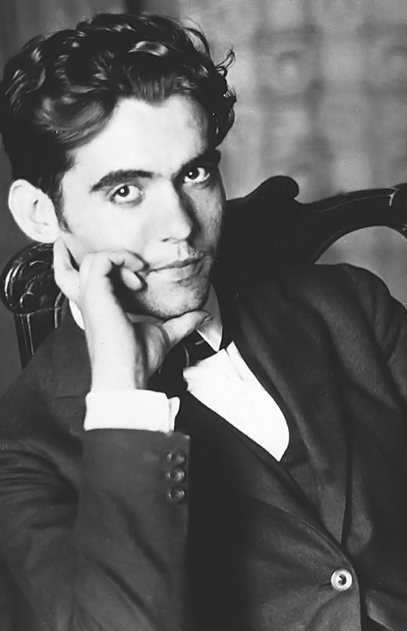

In [11]:
import cv2
img = cv2.imread('/content/gdrive/MyDrive/lorca/garcia_lorcaGR (1).jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

We will first process all his poems from that pdf

In [ ]:
!pip install tika

In [15]:
from tika import parser # pip install tika
raw = parser.from_file('/content/gdrive/MyDrive/lorca/federico-garcc3ada-lorca-obras-completas.pdf')

In [16]:
txt = raw['content']; txt[:1000]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nObras Completas\n\n\n\n\nAnnotation\n\nFederico\tGarcía\tLorca,\t uno\t de\t los\t poetas\tmás\t insignes\t de\t nuestra\t época,\t nació\t en\n1898,\t en\t Fuente\t Vaqueros\t (Granada)\t y\t murió\t fusilado\t por\t los\t rebeldes\t en\t 1936,\t al\ncomienzo\t de\t la\t Guerra\t Civil\t española.\t Desde\t que,\t en\t 1918,\t publicara\t su\t primer\t libro\nImpresiones\t y\t paisajes,\t escribió\t y\t publicó\t numerosas\t obras\t de\t poesía,\t drama\t y\t prosa,\nalgunas\tde\tlas\tcuales\tfueron\tinterrumpidas\tpor\tsu\tmuerte.\n\nEn\t esta\t recopilación\t de\t Obras\t Completas\t se\t han\t tomado\t como\t base\t las\t Obras\nCompletas\tde\tFederico\tGarcía\tLorca\tde\tla\tweb:\n\nhttp://www.culturandalucia.com/FEDERICO_GARCIA_LORCA/Federico_Garcia_Lorca_Obras.htm\n\nTambién\tse\than\ttenido\ten\tcuenta\tlos\tcontenidos\tsobre\tLorca\tde\tlos\tsitios:\thttp://fac-\nweb.spsu.edu,\thttp://www.

We will perform soe replacements to ensure the punktuation is treated as a separate token, and parenthesis and claudators are not considered.

In [17]:
tokens = txt.replace('[',"")
tokens = tokens.replace(']',"")
tokens = tokens.replace('(',"")
tokens = tokens.replace(')',"")
tokens = tokens.replace('.'," .")
tokens = tokens.replace(';'," ;")
tokens = tokens.replace(','," ,")
tokens[:1000]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nObras Completas\n\n\n\n\nAnnotation\n\nFederico\tGarcía\tLorca ,\t uno\t de\t los\t poetas\tmás\t insignes\t de\t nuestra\t época ,\t nació\t en\n1898 ,\t en\t Fuente\t Vaqueros\t Granada\t y\t murió\t fusilado\t por\t los\t rebeldes\t en\t 1936 ,\t al\ncomienzo\t de\t la\t Guerra\t Civil\t española .\t Desde\t que ,\t en\t 1918 ,\t publicara\t su\t primer\t libro\nImpresiones\t y\t paisajes ,\t escribió\t y\t publicó\t numerosas\t obras\t de\t poesía ,\t drama\t y\t prosa ,\nalgunas\tde\tlas\tcuales\tfueron\tinterrumpidas\tpor\tsu\tmuerte .\n\nEn\t esta\t recopilación\t de\t Obras\t Completas\t se\t han\t tomado\t como\t base\t las\t Obras\nCompletas\tde\tFederico\tGarcía\tLorca\tde\tla\tweb:\n\nhttp://www .culturandalucia .com/FEDERICO_GARCIA_LORCA/Federico_Garcia_Lorca_Obras .htm\n\nTambién\tse\than\ttenido\ten\tcuenta\tlos\tcontenidos\tsobre\tLorca\tde\tlos\tsitios:\thttp://fac-\nweb .spsu .edu

In [18]:
tokens = tokens.split()

In [19]:
vocab = L(*tokens).unique()
vocab


(#33913) ['Obras','Completas','Annotation','Federico','García','Lorca',',','uno','de','los'...]

I could not find a good rule of thumb to define the right sequence length. But considering we are working with poems, 40 tokens seems like a sufficiently long sequence. We will work directly for bigger sequence as the ones from the fastai course of 3-4 tokens is just too short for the complicated task, if no impossible, to model poetry.

In [20]:
seql = 40

We assign next to each token a number

In [21]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#340163) [0,1,2,3,4,5,6,7,8,9...]

We create sequences of the desired length, creating also the target variable as the next token.

In [23]:
seqs = L((tensor(nums[i:i+seql]), nums[i+seql]) for i in range(0,len(nums)-seql-1,seql))
seqs[1]

(tensor([32, 33, 34, 35,  6, 16, 36,  6, 37, 38, 39, 40, 41, 21, 42,  6, 43, 21, 44, 45, 46,  8, 47,  6, 48, 21, 49,  6, 50,  8, 51, 52, 53, 54, 24, 38, 55, 33, 56, 57]),
 58)

In [31]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

Out first model will be a shallow recurrent neural network, where we add an embedding layer to each new token. Note that the state h is reset to zero every sequence, so we are not properly managing memory, yet...

In [30]:
class LMModel(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        h = 0
        for i in range(seql):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

In [32]:
learn = Learner(dls, LMModel(len(vocab), 32), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,10.292473,10.015551,0.025867,00:10
1,7.744194,7.933124,0.041740,00:10
2,6.794331,8.025444,0.041740,00:10
3,6.549498,8.088206,0.044680,00:10


We will compare the accuracy against the one of predicting the most common token, let's see!

In [28]:
n,counts = 0,torch.zeros(len(vocab))
for x,y in dls.valid:
    n += y.shape[0]
    for i in range_of(vocab): counts[i] += (y==i).long().sum()
idx = torch.argmax(counts)
idx, vocab[idx.item()], counts[idx].item()/n

(tensor(6), ',', 0.053497942386831275)

We can see that we are only as good as our naive classifier that predict the most common token, which is a comma. We will be improving our model to get to significantly better results next.

### Updating the State

Note from LMModel that we are initializing our hidden state to zero for every new input sequence. Why is that a problem? We made our sample sequences short so they would fit easily into batches. But if we order the samples correctly, those sample sequences will be read in order by the model, exposing the model to long stretches of the original sequence.

Because we initialize the model's hidden state to zero for each new sample, we are throwing away all the information we have about the sentences we have seen so far, which means that our model doesn't actually know where we are up to in the overall counting sequence. This is easily fixed; we can simply move the initialization of the hidden state to __init__.

But this fix will create its own subtle, but important, problem. It effectively makes our neural network as deep as the entire number of tokens in our document. For instance, if there were 10,000 tokens in our dataset, we would be creating a 10,000-layer neural network.

The problem with a 10,000-layer neural network is that if and when you get to the 10,000th word of the dataset, you will still need to calculate the derivatives all the way back to the first layer. This is going to be very slow indeed, and very memory-intensive. It is unlikely that you'll be able to store even one mini-batch on your GPU.

The solution to this problem is to tell PyTorch that we do not want to back propagate the derivatives through the entire implicit neural network. Instead, we will just keep the last three layers of gradients. To remove all of the gradient history in PyTorch, we use the detach method.

Here is the new version of our RNN. It is now stateful, because it remembers its activations between different calls to forward, which represent its use for different samples in the batch:

In [38]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        for i in range(seql):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

To use LMModel2, we need to make sure the samples are going to be seen in a certain order. If the first line of the first batch is our dset[0] then the second batch should have dset[1] as the first line, so that the model sees the text flowing.

To do this, we are going to rearrange our dataset. First we divide the samples into m = len(dset) // bs groups (this is the equivalent of splitting the whole concatenated dataset into, for example, 64 equally sized pieces, since we're using bs=64 here). m is the length of each of these pieces. For instance, if we're using our whole dataset (although we'll actually split it into train versus valid in a moment), that will be:

In [34]:
m = len(seqs)//bs
m,bs,len(seqs)

(132, 64, 8504)

In [35]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

Then we just pass drop_last=True when building our DataLoaders to drop the last batch that does not have a shape of bs. We also pass shuffle=False to make sure the texts are read in order:

In [42]:
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

In [44]:
learn2 = Learner(dls, LMModel2(len(vocab), 64), loss_func=F.cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
learn2.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,10.400837,10.326013,0.004207,00:18
1,8.193347,7.917175,0.041466,00:17
2,6.559291,8.219725,0.050481,00:17
3,5.880213,8.331513,0.058894,00:17
4,5.395540,8.354427,0.060697,00:17
5,4.973046,8.742318,0.063101,00:17
6,4.652388,9.030555,0.061298,00:17
7,4.461773,9.107494,0.057692,00:17
8,4.369677,9.066630,0.069111,00:17
9,4.287122,9.115159,0.067909,00:17


It already get better, let's know allow the model to learn from its intermmediate outputs and not only the final token prediction error.

### Creating more signal

Another problem with our current approach is that we only predict one output word for each three input words. That means that the amount of signal that we are feeding back to update weights with is not as large as it could be. It would be better if we predicted the next word after every single word

In [45]:
sl = 40
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

In [47]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#40) ['Obras','Completas','Annotation','Federico','García','Lorca',',','uno','de','los'...],
 (#40) ['Completas','Annotation','Federico','García','Lorca',',','uno','de','los','poetas'...]]

Now we need to modify our model so that it outputs a prediction after every word, rather than just at the end of the sequence:

In [46]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h)) # output a prediction after each word
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self): self.h = 0

This model will return outputs of shape bs x sl x vocab_sz (since we stacked on dim=1). Our targets are of shape bs x sl, so we need to flatten those before using them in F.cross_entropy:

In [49]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [ ]:
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time


We need to train for longer, since the task has changed a bit and is more complicated now. But we end up with a good result... At least, sometimes. If you run it a few times, you'll see that you can get quite different results on different runs. That's because effectively we have a very deep network here, which can result in very large or very small gradients. We'll see in the next part of this chapter how to deal with this.

Now, the obvious way to get a better model is to go deeper: we only have one linear layer between the hidden state and the output activations in our basic RNN, so maybe we'll get better results with more.

In [ ]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [ ]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,8.346545,8.337866,0.000391,00:01
1,8.328381,8.286561,0.000391,00:01
2,8.271790,8.035854,0.049219,00:01
3,8.080894,7.346517,0.064453,00:01
4,7.779276,6.876366,0.050781,00:01
5,7.493887,6.804914,0.051562,00:01
6,7.278198,6.879838,0.054297,00:01
7,7.117814,6.931529,0.050000,00:01
8,6.991854,6.957365,0.050000,00:01
9,6.890099,6.977496,0.049219,00:01


In [ ]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [ ]:
learn = Learner(dls, LMModel6(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.342263,8.332246,0.001563,00:01
1,8.318126,8.207052,0.016016,00:01
2,8.074806,7.034512,0.017188,00:01
3,7.637185,7.098006,0.052734,00:01
4,7.352601,7.232337,0.053516,00:01
5,7.147218,7.363180,0.048828,00:01
6,6.996726,7.406292,0.050781,00:01
7,6.882939,7.430689,0.053125,00:01
8,6.793693,7.451829,0.048047,00:01
9,6.722270,7.464892,0.048828,00:01


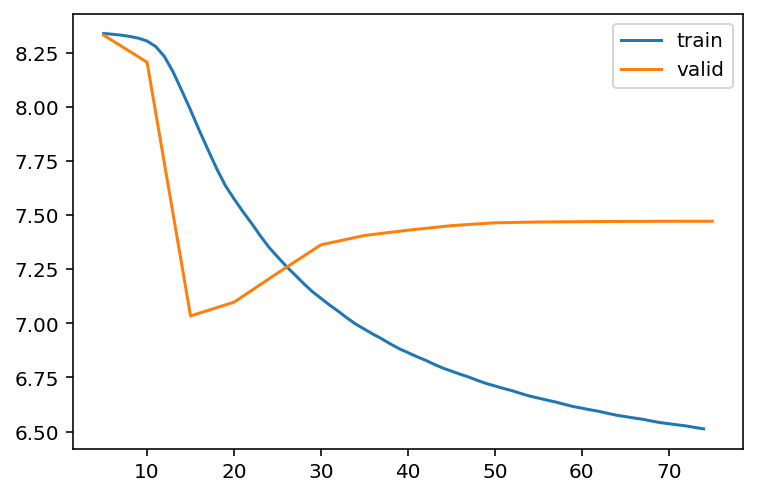

In [ ]:
learn.recorder.plot_loss()

In [ ]:
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-p)
        return x * mask.div_(1-p)

In [ ]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

In [ ]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

In [ ]:
learn.fit_one_cycle(25, 3e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time


AttributeError: ignored

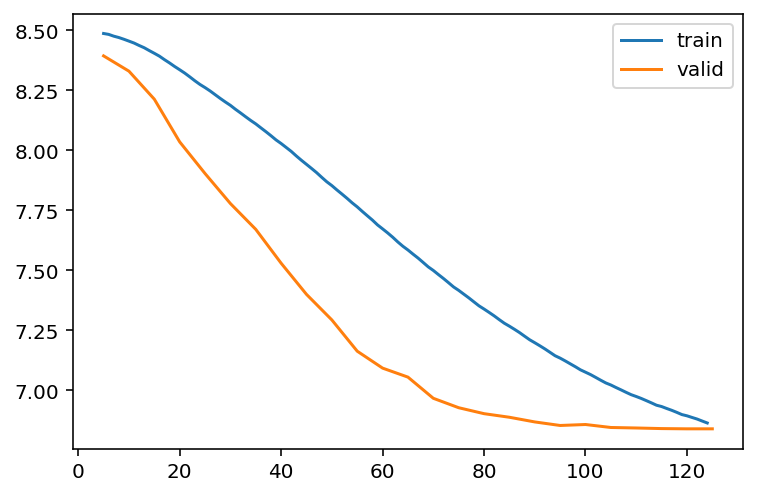

In [ ]:
learn.recorder.plot_loss()

In [ ]:
df = pd.DataFrame({'col':tokens})

In [ ]:
df = pd.DataFrame([sub.split(";") for sub in [' '.join(tokens)]])

In [ ]:
df = df.transpose()


In [ ]:
df['text2'] = 0

In [ ]:
df.columns = ['text', 'textfalse']

In [ ]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),get_x=ColReader('text'),splitter=RandomSplitter(0.2))

dls_lm = dls_lm.dataloaders(df, bs=40)
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos no soy xxunk de la xxmaj xxunk xxmaj xxunk . xxup tío xxmaj cada uno vive como puede o como sabe en esta vida xxunk . xxup señor x xxmaj está entendido , la xxmaj tierra es un xxunk xxunk , pero hay que ayudar a la civilización . xxmaj si xxmaj santos xxmaj xxunk , en vez de estudiar xxmaj xxunk xxunk , se hubiera xxunk a cuidar rosas ,","no soy xxunk de la xxmaj xxunk xxmaj xxunk . xxup tío xxmaj cada uno vive como puede o como sabe en esta vida xxunk . xxup señor x xxmaj está entendido , la xxmaj tierra es un xxunk xxunk , pero hay que ayudar a la civilización . xxmaj si xxmaj santos xxmaj xxunk , en vez de estudiar xxmaj xxunk xxunk , se hubiera xxunk a cuidar rosas , el"
1,"rodeados de una belleza natural única , no esperan nada y sólo saben sonreír . xxmaj el viajero poco xxunk encontrará con la variación increíble de formas , de paisaje , de luz y de olor la sensación de que xxmaj granada es capital de un reino con arte y literatura propios , y xxunk una curiosa xxunk de la xxmaj granada judía y la xxmaj granada xxunk , xxunk fundidas por","de una belleza natural única , no esperan nada y sólo saben sonreír . xxmaj el viajero poco xxunk encontrará con la variación increíble de formas , de paisaje , de luz y de olor la sensación de que xxmaj granada es capital de un reino con arte y literatura propios , y xxunk una curiosa xxunk de la xxmaj granada judía y la xxmaj granada xxunk , xxunk fundidas por el"


In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
learn.fit_one_cycle(100,1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,7.148681,7.026443,0.100724,1126.018799,00:14
1,6.909768,6.752982,0.105498,856.609070,00:14
2,6.649330,6.472504,0.114468,647.101807,00:14
3,6.352115,6.176492,0.126525,481.300446,00:14
4,6.076687,5.882262,0.139444,358.619598,00:14
5,5.795281,5.637851,0.150013,280.858429,00:14
6,5.584991,5.477872,0.157241,239.336823,00:14
7,5.440235,5.372392,0.164910,215.377365,00:14
8,5.333639,5.282372,0.173768,196.836304,00:14
9,5.230339,5.195711,0.182910,180.496460,00:15


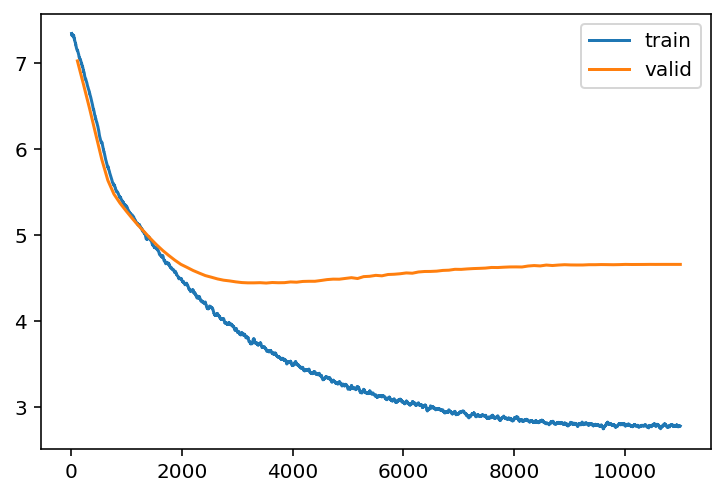

In [ ]:
learn.recorder.plot_loss()

In [ ]:
TEXT = 'Viva el mar, las estrellas. Los horizontes infinitos y la lluvia suave.' 
N_WORDS = 40
N_SENTENCES = 5
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
preds

['Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Hoy perfume y de nardos , lengua comen , tú sabes que rompe una columna . El mar día . Nadie en el mundo . Cuando no se clavan inmensa tierra de tierra tierra .',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Agua y espuma , y ceniza de ceniza . Hoy musgo sobre las ondas estrellas . Agua sobre las olas . Agua estancada a los álamos . Fuente de la seda negra . Agua',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . No es posible que no florecieron . Pero no la ciudad se va y cuando el aire tú no me gusta más que el mar . No lo extraño que te gusta . y no quiero decir',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Profundo y profundo , profundo y profundo , pero un frescor de enagua . Profundo y profundo , profundo , profundo , profundo , profundo y profundo , sin que profundo , profundo , profundo , profundo ,',
 'Viva el

In [ ]:
preds

['Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Un OTOÑO en la gran sombra de la vientos . La Muerte Satán el alma del árbol . Doña Muerte , La Muerte Un Campo De Cristo',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . CANCION DIJO Rojo Un un viejo claras de la luz , y un ciencia de los silencio . Las estrellas y un campo de plata marchita . Un fondo de niebla de horas con',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Un aire en un amor y la luna que el que una mañana por la fuente del bosque de los años cadencia , y los niños y y los campos y inmortal ! Los árboles donde los mares']